In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

# Load Data

In [2]:
# Import data into a dataframe
train= pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test= pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
print(f"Train Data Info: {train.info()}\n")
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
Train Data Info: None



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(f"Test Data Info: {test.info()}\n")
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
Test Data Info: None



,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train dataset contains the target and features columns, it has a shape of 785 columns and 42000 rows/observations,while the test dataset contains just the features columns, and is a shape of 784 columns and 28000 rows/observations.

# Split Training Dataset to Targets and Features

In [5]:
target= train["label"]
features= train.drop("label", axis=1)

In [6]:
print(f"Target type: {type(target)}\n")
print(f"Features type: {type(features)}")

Target type: <class 'pandas.core.series.Series'>

Features type: <class 'pandas.core.frame.DataFrame'>


In [7]:
print(target.head())
features.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


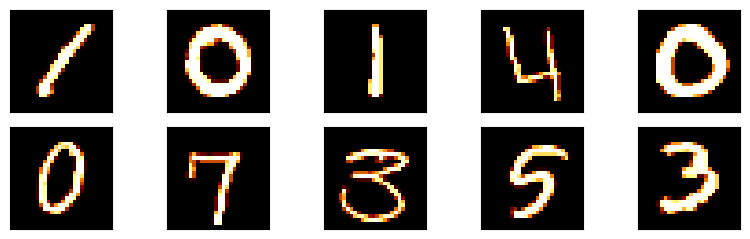

In [8]:
# plot some of the numbers
plt.figure(figsize=(8,6))
for digit_num in range(0,10):
    plt.subplot(5,5,digit_num+1)
    grid_data = features.iloc[digit_num].to_numpy().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [9]:
# Basic analysis
bstats= {"mean": np.mean(features, axis=1), "variance": np.var(features, axis=1), "std":np.std(features, axis=1) }
stats=pd.DataFrame(bstats)
stats

,mean,variance,std
0,21.235969,4175.613961,64.618991
1,56.899235,9830.412040,99.148434
2,17.123724,3554.649233,59.620879
3,19.164541,3335.083896,57.750185
4,65.169643,10982.077089,104.795406
...,...,...,...
41995,37.385204,6493.440904,80.581889
41996,17.110969,3638.376716,60.318958
41997,40.183673,7614.802999,87.262839
41998,33.649235,6232.265994,78.944702


array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'variance'}>],
       [<Axes: title={'center': 'std'}>, <Axes: >]], dtype=object)

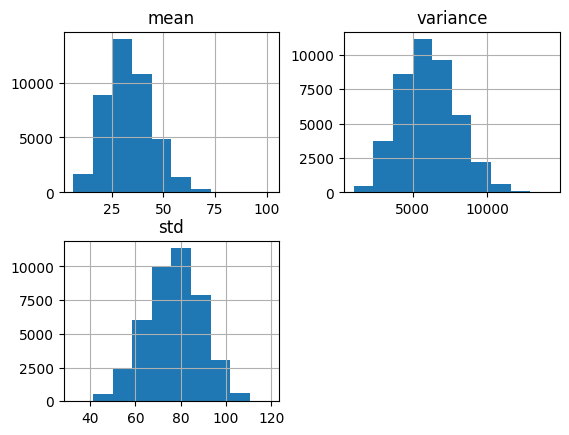

In [10]:
stats.hist()

# Preprocessing the Datasets
#### Features
- **Data Noramlization** scales the pixel values to a certain range (usually 0 to 1), which can help with numerical stability and also ensure that all features have the same scale.
- **Standardize** makes the features more like standard normally distributed data: Gaussian with zero mean and unit variance
- **Scaling Data** is necessary because many machine learning algorithms (especially deep learning algorithms) expect input data in a certain shape.

In [11]:
def preprocess_data(data):
    # Normalize the data
    feat_norm = data / 255.0

    # Initialize a new StandardScaler instance
    scaler = StandardScaler()

    # Fit the scaler to the data
    scaler.fit(feat_norm)

    # Transform the data
    feat_scaled = scaler.transform(feat_norm)
    
    # Reshape the data to 28x28 images
    feat_reshape = feat_scaled.reshape(-1, 28, 28)
    
    return feat_reshape


In [12]:
feat_train= preprocess_data(features)
feat_test= preprocess_data(test)

In [13]:
# Datatype
print(f"Train Scaled DataType: {type(feat_train)}")
print(f"Test Scaled DataType: {type(feat_test)}")

Train Scaled DataType: <class 'numpy.ndarray'>
Test Scaled DataType: <class 'numpy.ndarray'>


In [14]:
# Printing the Data
print(f"Train Scaled Data: \n {feat_train[0:5]}\n")
print(f"Test Scaled Data: \n {feat_test[0:5]}")

Train Scaled Data: 
 [[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.         -0.00487956 ... -0.00805699  0.
    0.        ]
  ...
  [ 0.          0.         -0.00796544 ... -0.00678334 -0.00487956
    0.        ]
  [ 0.          0.          0.         ... -0.00487956  0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.         -0.00487956 ... -0.00805699  0.
    0.        ]
  ...
  [ 0.          0.         -0.00796544 ... -0.00678334 -0.00487956
    0.        ]
  [ 0.          0.          0.         ... -0.00487956  0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0. 

In [15]:
print(f"Train Scaled Data Shape: \n {feat_train.shape}\n")
print(f"Test Scaled Data Shape: \n {feat_test.shape}")

Train Scaled Data Shape: 
 (42000, 28, 28)

Test Scaled Data Shape: 
 (28000, 28, 28)


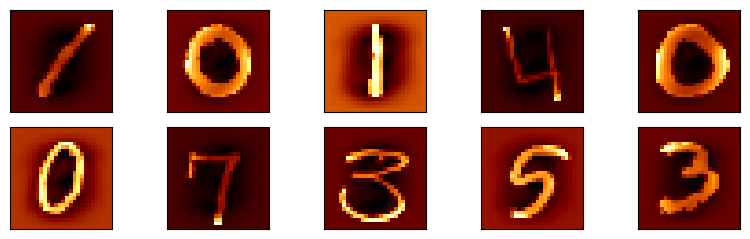

In [16]:
# plot some of the numbers preprocessed image
plt.figure(figsize=(8,6))
for digit_num in range(0,10):
    plt.subplot(5,5,digit_num+1)
    grid_data = feat_train[digit_num]
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

#### Target

**One Hot encoding of labels** 

A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the nth digit will be represented as a vector which is 1 in the nth dimension

In [17]:
cat_target= to_categorical(target, )
target_classes = cat_target.shape[1]
print(cat_target)
print(f"Classes: {target_classes}")


[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Classes: 10


/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


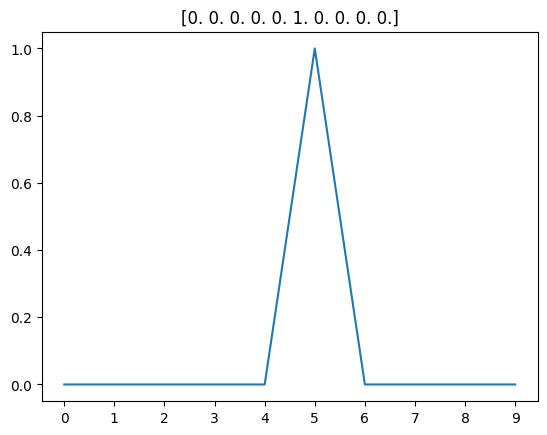

In [18]:
plt.title(cat_target[8])
plt.plot(cat_target[8])
plt.xticks(range(10));

The vector is 5

# Feature Extraction

Principal Component Analysis (PCA) is a linear transformation algorithm that seeks to project the original features of our data onto a smaller set of features ( or subspace ) while still retaining most of the information.

In [19]:
# Assuming 'features' is your original data
feat_train_reshaped = feat_train.reshape((feat_train.shape[0], feat_train.shape[1] * feat_train.shape[2]))
feat_test_reshaped = feat_test.reshape((feat_test.shape[0], feat_test.shape[1] * feat_test.shape[2]))

pca= PCA(0.95)
pca.fit(feat_train_reshaped)
train_pca= pca.transform(feat_train_reshaped)
test_pca= pca.transform(feat_test_reshaped)

In [20]:
print(f"Shape of Dataset: {train_pca}")

Shape of Dataset: [[ -5.14047772  -5.2264454    3.88700075 ...   0.2522825   -0.30099636
   -0.07857859]
 [ 19.29233234   6.03299601   1.30814797 ...  -0.15687518  -0.26198889
    0.22004628]
 [ -7.64450341  -1.70581328   2.28932646 ...   0.22375157  -0.04941062
   -0.22325326]
 ...
 [  0.49539137   7.07627667 -12.08969955 ...  -0.12348149  -0.08188437
    0.04023504]
 [  2.30724011  -4.34451279   0.6998478  ...  -0.46288052   0.5304089
   -0.7321853 ]
 [ -4.80767022   1.55912058  -2.49793585 ...  -0.88325339  -0.54571201
   -0.27910786]]


# Test Train Split

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_pca, cat_target, test_size=0.2, random_state=42)

# Build Model
The input shape for the first layer is 50 because you mentioned your data from the reduced_train is 50.
The final layer uses softmax activation function because this is a multi-class classification problem.

In [22]:
# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(train_pca.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(target_classes, activation='softmax'))  # target classes 10

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               41088     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 55,914
Trainable params: 55,914
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
525/525 [==============================] - 3s 3ms/step - loss: 0.5063 - accuracy: 0.8555
Epoch 2/20
525/525 [==============================] - 1s 3ms/step - loss: 0.1597 - accuracy: 0.9541
Epoch 3/20
525/525 [==============================] - 1s 3ms/step - loss: 0.1119 - accuracy: 0.9683
Epoch 4/20
525/525 [==============================] - 1s 3ms/step - loss: 0.0787 - accuracy: 0.9784
Epoch 5/20
525/525 [==============================] - 1s 3ms/step - loss: 0.0603 - accuracy: 0.9832
Epoch 6/20
525/525 [==============================] - 1s 3ms/step - loss: 0.0509 - accuracy: 0.9855
Epoch 7/20
525/525 [==============================] - 1s 3ms/step - loss: 0.0412 - accuracy: 0.9883
Epoch 8/20
525/525 [==============================] - 1s 3ms/step - loss: 0.0410 - accuracy: 0.9885
Epoch 9/20
525/525 [==============================] - 1s 3ms/step - loss: 0.0284 - accuracy: 0.9917
Epoch 10/20
525/525 [==============================] - 1s 3ms/step - loss: 0.0349 - accuracy: 0.9910

In [25]:
model.fit(train_pca, cat_target, epochs=1, batch_size=64)

657/657 [==============================] - 2s 3ms/step - loss: 0.0685 - accuracy: 0.9842


In [26]:
predictions = model.predict(test_pca, verbose=0)

In [27]:
print(predictions.shape)
type(predictions)
predictions[0]

(28000, 10)


array([7.1862161e-13, 3.7824850e-07, 9.9999958e-01, 3.3244166e-10,
       2.1479092e-16, 6.2197534e-14, 1.5659016e-10, 2.1287399e-09,
       7.4876866e-14, 5.2293740e-17], dtype=float32)

In [28]:
predicted_labels= []
for n in range(len(predictions)):
    predicted_labels.append(np.argmax(predictions[n]))
# predicted_labels= print(predictions.shape)
predicted_labels[0:5]

[2, 0, 8, 9, 3]

In [29]:
submission=pd.DataFrame({"ImageId": list(range(1,len(predicted_labels)+1)),
                         "Label": predicted_labels})

submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,8
3,4,9
4,5,3
